In [57]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='06da6cb9-f521-4637-8e87-58eebbd84d75', project_access_token='p-2+ha5jHooHijO2exOzS6WcdQ==;n/2/fdaCyiJw+mTCb/yDzg==:esPOqW4sNpWgURM0YeFi8Px2AdS25FkJVceNpUlMHPcWajXPslWcDUGhuaV1nk+DgQhZEKSRygp/eG8WccPYajZkNL0KSrQEnA==')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'p-2+ha5jHooHijO2exOzS6WcdQ==;n/2/fdaCyiJw+mTCb/yDzg==:esPOqW4sNpWgURM0YeFi8Px2AdS25FkJVceNpUlMHPcWajXPslWcDUGhuaV1nk+DgQhZEKSRygp/eG8WccPYajZkNL0KSrQEnA=='})



In [1]:
!pip install natsort
!pip install tensorflow_datasets
!pip install isic-cli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.11.2
    Uninstalling Pygments-2.11.2:
      Successfully uninstalled Pygments-2.11.2


In [2]:
#imports
from zipfile import ZipFile
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import io
import numpy as np
import random
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split

In [11]:
!mkdir preprocessed
!isic image download --limit 0 --search 'benign_malignant:malignant' preprocessed/malignant 
!isic image download --limit 10000 --search 'benign_malignant:benign' preprocessed/benign 

Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 7,361 images to preprocessed/malignant/.
Successfully wrote 7,361 metadata records to preprocessed/malignant/metadata.csv.
Successfully wrote attributions to preprocessed/malignant/attribution.txt.
Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 10,000 images to preprocessed/benign/.
Successfully wrote 10,000 metadata records to preprocessed/benign/metadata.csv.
Successfully wrote attributions to preprocessed/benign/attribution.txt.


In [12]:
!ls 

efficient_net_weights	   preprocessed
efficient_net_weights.zip  preprocessed.zip


In [14]:
malignant_csv = pd.read_csv('preprocessed/malignant/metadata.csv')
benign_csv = pd.read_csv('preprocessed/benign/metadata.csv')
metadata = pd.concat([malignant_csv, benign_csv])

# Creating tensorflow dataset

In [15]:
metadata.columns

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'dermoscopic_type', 'diagnosis',
       'diagnosis_confirm_type', 'family_hx_mm', 'image_type', 'lesion_id',
       'mel_class', 'mel_mitotic_index', 'mel_thick_mm', 'mel_type',
       'mel_ulcer', 'melanocytic', 'patient_id', 'personal_hx_mm', 'pixels_x',
       'pixels_y', 'sex', 'nevus_type'],
      dtype='object')

In [16]:
benign_count = len(metadata[ metadata['benign_malignant'] == 'benign'])
malignant_count = len(metadata[ metadata['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(benign_count)
print(malignant_count)
print(malignant_frac)


10000
7361
42.399631357640686


In [18]:
f = 0.2
train_df, test_df = train_test_split(metadata, test_size=f)
train_df, val_df = train_test_split(train_df, test_size=f)


benign_count = len(train_df[ train_df['benign_malignant'] == 'benign'])
malignant_count = len(train_df[ train_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 6461
Malignant: 4649
Malignant fraction: 41.85%


In [19]:
benign_count = len(val_df[ val_df['benign_malignant'] == 'benign'])
malignant_count = len(val_df[ val_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 1561
Malignant: 1217
Malignant fraction: 43.81%


In [20]:
benign_count = len(test_df[ test_df['benign_malignant'] == 'benign'])
malignant_count = len(test_df[ test_df['benign_malignant'] == 'malignant'])
malignant_frac = malignant_count / (benign_count + malignant_count) * 100

print(f"Benign: {benign_count}")
print(f"Malignant: {malignant_count}")
print(f"Malignant fraction: {malignant_frac:.2f}%")

Benign: 1978
Malignant: 1495
Malignant fraction: 43.05%


In [21]:
train_df

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,dermoscopic_type,diagnosis,...,mel_thick_mm,mel_type,mel_ulcer,melanocytic,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,nevus_type
9601,ISIC_9440209,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,NaN,30.0,anterior torso,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,IP_2166250,NaN,640,480,male,NaN
4718,ISIC_9483417,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,NaN,35.0,anterior torso,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,IP_9711347,NaN,640,480,male,NaN
8073,ISIC_8792193,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,NaN,45.0,lower extremity,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,IP_8029095,NaN,640,480,female,NaN
6708,ISIC_0011695,Anonymous,CC-0,NaN,35.0,posterior torso,malignant,NaN,contact non-polarized,melanoma,...,NaN,NaN,NaN,True,NaN,NaN,6610,4412,female,NaN
1323,ISIC_3060145,Memorial Sloan Kettering Cancer Center,CC-0,NaN,70.0,lateral torso,benign,8.9,contact non-polarized,nevus,...,NaN,NaN,NaN,True,IP_2698506,True,3264,2448,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,ISIC_3749849,Hospital Italiano de Buenos Aires,CC-BY-NC,NaN,75.0,upper extremity,malignant,NaN,contact polarized,squamous cell carcinoma,...,NaN,NaN,NaN,NaN,IP_1418688,NaN,4032,3024,female,NaN
1980,ISIC_0071192,Hospital Clínic de Barcelona,CC-BY-NC,NaN,35.0,head/neck,malignant,NaN,NaN,melanoma,...,NaN,NaN,NaN,True,NaN,NaN,1024,1024,male,NaN
3147,ISIC_0062827,Hospital Clínic de Barcelona,CC-BY-NC,NaN,65.0,lower extremity,malignant,NaN,NaN,melanoma,...,NaN,NaN,NaN,True,NaN,NaN,1024,1024,female,NaN
5808,ISIC_4181628,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,NaN,25.0,posterior torso,benign,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,IP_6614604,NaN,1872,1053,male,NaN


In [313]:
pos_features = train_df[ train_df['benign_malignant'] == 'malignant'].reset_index()
neg_features = train_df[ train_df['benign_malignant'] == 'benign'].reset_index()

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features.iloc[choices]
res_df = pd.concat([res_pos_features, neg_features])

neg = len(neg_features)
print(neg_features.shape)
print(pos_features.shape)
print(res_pos_features.shape)
print(res_df.shape)

(2074, 27)
(382, 27)
(2074, 27)
(4148, 27)


In [24]:
import shutil
import os

def local_filename(row):
    return row['isic_id'] + ".JPG"

def download_df(df, folder="cancer"):

    def save_image(img_name, path_prefix, source_folder="preprocessed"):
        src_filepath = os.path.join(source_folder, img_name)
        dest_filepath = os.path.join(path_prefix, img_name)
        shutil.copy2(src_filepath, dest_filepath)

    benin = df[df['benign_malignant'] == 'benign']
    malignat = df[df['benign_malignant'] == 'malignant']

    benin_filenames = benin.apply(local_filename, axis=1)
    malignat_filenames = malignat.apply(local_filename, axis=1)

    p = os.path.join(folder, "")
    os.makedirs(p, exist_ok=True)
    benin_path = os.path.join(p, 'benign')
    os.makedirs(benin_path, exist_ok=True)
    malignat_path = os.path.join(p, 'malignant')
    os.makedirs(malignat_path, exist_ok=True)

    for img_name in benin_filenames:
        save_image(img_name, benin_path, "preprocessed/benign")

    for img_name in malignat_filenames:
        save_image(img_name, malignat_path, "preprocessed/malignant")

In [25]:
download_df(train_df, "cancer/train")

In [26]:
download_df(val_df, "cancer/val")

In [27]:
download_df(test_df, "cancer/test")

In [28]:
!ls -l cancer/train/benign

total 1323396
-rw------- 1 wsuser wscommon  215755 Jun 19 21:16 ISIC_0068279.JPG
-rw------- 1 wsuser wscommon  548264 Jun 19 21:12 ISIC_0098024.JPG
-rw------- 1 wsuser wscommon  510329 Jun 19 21:12 ISIC_0101540.JPG
-rw------- 1 wsuser wscommon  606017 Jun 19 21:13 ISIC_0103730.JPG
-rw------- 1 wsuser wscommon  964128 Jun 19 21:11 ISIC_0115851.JPG
-rw------- 1 wsuser wscommon  784936 Jun 19 21:13 ISIC_0118792.JPG
-rw------- 1 wsuser wscommon  468432 Jun 19 21:12 ISIC_0119296.JPG
-rw------- 1 wsuser wscommon  220453 Jun 19 21:11 ISIC_0125986.JPG
-rw------- 1 wsuser wscommon  598562 Jun 19 21:12 ISIC_0126191.JPG
-rw------- 1 wsuser wscommon  545914 Jun 19 21:12 ISIC_0134155.JPG
-rw------- 1 wsuser wscommon  657370 Jun 19 21:13 ISIC_0135990.JPG
-rw------- 1 wsuser wscommon 1259928 Jun 19 21:13 ISIC_0136396.JPG
-rw------- 1 wsuser wscommon  160139 Jun 19 21:12 ISIC_0141408.JPG
-rw------- 1 wsuser wscommon 1065828 Jun 19 21:12 ISIC_0141681.JPG
-rw------- 1 wsuser wscommon   36842 Jun 19 21:1

In [269]:
!ls -l cancer/

total 12
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 test
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 train
drwxrwx--- 4 wsuser wscommon 4096 Jun 19 19:46 val


In [51]:
img_height, img_width = 240, 240
# img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

val_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

test_ds = tf.keras.utils.image_dataset_from_directory(
    "cancer/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary')


Found 11110 files belonging to 2 classes.
Found 2778 files belonging to 2 classes.
Found 3473 files belonging to 2 classes.


In [31]:
class_names = train_ds.class_names
print(class_names)


['benign', 'malignant']


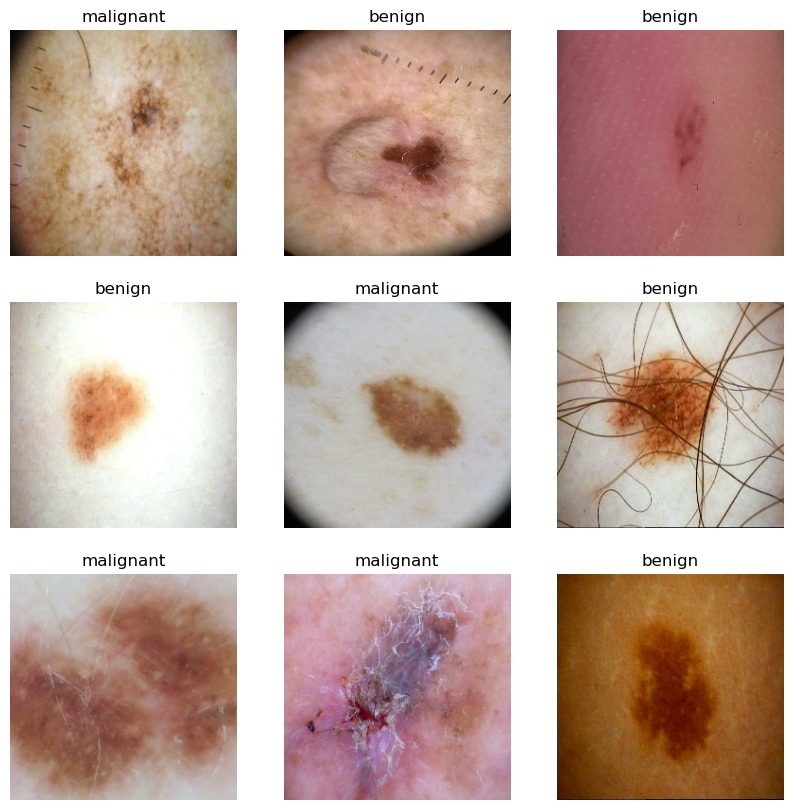

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i] > 0.5)])
    plt.axis("off")


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer learning

In [35]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


inputs = layers.Input(shape=(img_height, img_width, 3))
x = img_augmentation(inputs)
model = eff_model = EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_tensor=x
  )

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="max_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)


# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS
)


# list(map(lambda x: x.name, model.layers[-34:]))

In [277]:
def plot_hist(hist):
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [36]:
epochs = 50


# resampled_steps_per_epoch = np.ceil(2.0*neg/batch_size)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


hist = model.fit(
    train_ds, 
#     steps_per_epoch=20, 
    epochs=epochs,
    validation_data=val_ds, 
    callbacks = [early_stopping],
    verbose=2,
#     class_weight = class_weight
)
# plot_hist(hist)


Epoch 1/50


2023-06-19 21:23:31.189588: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-19 21:23:31.191239: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


348/348 - 140s - loss: 0.4354 - tp: 3515.0000 - fp: 969.0000 - tn: 5492.0000 - fn: 1134.0000 - accuracy: 0.8107 - precision: 0.7839 - recall: 0.7561 - auc: 0.8823 - prc: 0.8504 - val_loss: 0.3613 - val_tp: 911.0000 - val_fp: 98.0000 - val_tn: 1463.0000 - val_fn: 306.0000 - val_accuracy: 0.8546 - val_precision: 0.9029 - val_recall: 0.7486 - val_auc: 0.9224 - val_prc: 0.9109 - 140s/epoch - 403ms/step
Epoch 2/50
348/348 - 142s - loss: 0.3580 - tp: 3721.0000 - fp: 728.0000 - tn: 5733.0000 - fn: 928.0000 - accuracy: 0.8509 - precision: 0.8364 - recall: 0.8004 - auc: 0.9189 - prc: 0.9008 - val_loss: 0.3391 - val_tp: 970.0000 - val_fp: 124.0000 - val_tn: 1437.0000 - val_fn: 247.0000 - val_accuracy: 0.8665 - val_precision: 0.8867 - val_recall: 0.7970 - val_auc: 0.9272 - val_prc: 0.9169 - 142s/epoch - 409ms/step
Epoch 3/50
348/348 - 144s - loss: 0.3398 - tp: 3785.0000 - fp: 676.0000 - tn: 5785.0000 - fn: 864.0000 - accuracy: 0.8614 - precision: 0.8485 - recall: 0.8142 - auc: 0.9257 - prc: 0.911

In [37]:
list(map(lambda x: x.name, model.layers[-36:]))

['block6e_add',
 'block7a_expand_conv',
 'block7a_expand_bn',
 'block7a_expand_activation',
 'block7a_dwconv',
 'block7a_bn',
 'block7a_activation',
 'block7a_se_squeeze',
 'block7a_se_reshape',
 'block7a_se_reduce',
 'block7a_se_expand',
 'block7a_se_excite',
 'block7a_project_conv',
 'block7a_project_bn',
 'block7b_expand_conv',
 'block7b_expand_bn',
 'block7b_expand_activation',
 'block7b_dwconv',
 'block7b_bn',
 'block7b_activation',
 'block7b_se_squeeze',
 'block7b_se_reshape',
 'block7b_se_reduce',
 'block7b_se_expand',
 'block7b_se_excite',
 'block7b_project_conv',
 'block7b_project_bn',
 'block7b_drop',
 'block7b_add',
 'top_conv',
 'top_bn',
 'top_activation',
 'max_pool',
 'batch_normalization',
 'top_dropout',
 'pred']

In [39]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-35:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS
    )


unfreeze_model(model)

epochs = 100  # @param {type: "slider", min:8, max:50}
hist = model.fit(
    train_ds, 
#     steps_per_epoch=20, 
    epochs=epochs,
    validation_data=val_ds, 
    callbacks = [early_stopping],
    verbose=2,
#     class_weight = class_weight
)

# # plot_hist(hist)

Epoch 1/100
348/348 - 136s - loss: 0.3015 - tp: 4876.0000 - fp: 692.0000 - tn: 7330.0000 - fn: 990.0000 - accuracy: 0.8789 - precision: 0.8757 - recall: 0.8312 - auc: 0.9408 - prc: 0.9281 - val_loss: 0.2767 - val_tp: 1001.0000 - val_fp: 62.0000 - val_tn: 1499.0000 - val_fn: 216.0000 - val_accuracy: 0.8999 - val_precision: 0.9417 - val_recall: 0.8225 - val_auc: 0.9530 - val_prc: 0.9489 - 136s/epoch - 390ms/step
Epoch 2/100
348/348 - 124s - loss: 0.2673 - tp: 3999.0000 - fp: 508.0000 - tn: 5953.0000 - fn: 650.0000 - accuracy: 0.8958 - precision: 0.8873 - recall: 0.8602 - auc: 0.9543 - prc: 0.9468 - val_loss: 0.2779 - val_tp: 1086.0000 - val_fp: 179.0000 - val_tn: 1382.0000 - val_fn: 131.0000 - val_accuracy: 0.8884 - val_precision: 0.8585 - val_recall: 0.8924 - val_auc: 0.9529 - val_prc: 0.9501 - 124s/epoch - 357ms/step
Epoch 3/100
348/348 - 123s - loss: 0.2407 - tp: 4052.0000 - fp: 453.0000 - tn: 6008.0000 - fn: 597.0000 - accuracy: 0.9055 - precision: 0.8994 - recall: 0.8716 - auc: 0.96

In [40]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)



  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [52]:
def get_truth_labels(ds):
    truth_labels = list()
    benign_test = 0
    malignant_test = 0
    for image_batch, labels_batch in ds:
        for label in labels_batch:
            truth_labels.append(label.numpy()[0])
            if label == 0:
                benign_test += 1
            else:
                malignant_test += 1

    print(benign_test)
    print(malignant_test)
    print(malignant_test / (benign_test + malignant_test))
    return truth_labels

109/109 [==============================] - 4s 40ms/step
1978
1495
0.4304635761589404


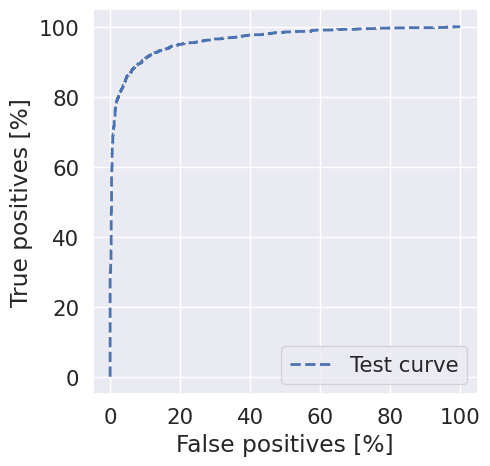

In [61]:
test_predictions = model.predict(test_ds)
test_labels = get_truth_labels(test_ds)


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Test ROC", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [63]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


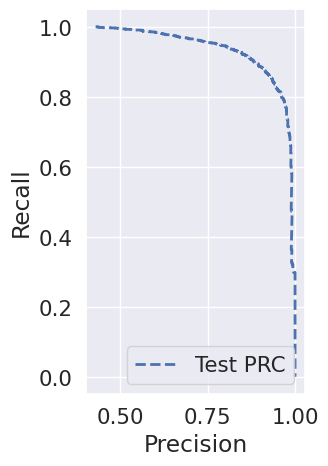

In [65]:
plot_prc("Test PRC", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [54]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

109/109 [==============================] - 5s 47ms/step - loss: 0.2447 - tp: 1324.0000 - fp: 147.0000 - tn: 1831.0000 - fn: 171.0000 - accuracy: 0.9084 - precision: 0.9001 - recall: 0.8856 - auc: 0.9627 - prc: 0.9576


[0.2446918934583664,
 1324.0,
 147.0,
 1831.0,
 171.0,
 0.9084365367889404,
 0.9000679850578308,
 0.8856187462806702,
 0.9626744985580444,
 0.9576141834259033]

In [59]:
import io

filename = "./efficient_net_weights/efficient_net_weights"
!mkdir "efficient_net_weights"
model.save_weights(filename)
model.load_weights(filename)
!zip -r efficient_net_weights.zip efficient_net_weights


with open('efficient_net_weights.zip', 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(
            'efficient_net_weights_transfer_balanced_final.zip', data, set_project_asset=True, overwrite=True
        )

mkdir: cannot create directory ‘efficient_net_weights’: File exists
updating: efficient_net_weights/ (stored 0%)
updating: efficient_net_weights/checkpoint (deflated 41%)
updating: efficient_net_weights/efficient_net_weights.data-00000-of-00001 (deflated 7%)
updating: efficient_net_weights/efficient_net_weights.index (deflated 77%)


109/109 [==============================] - 5s 41ms/step


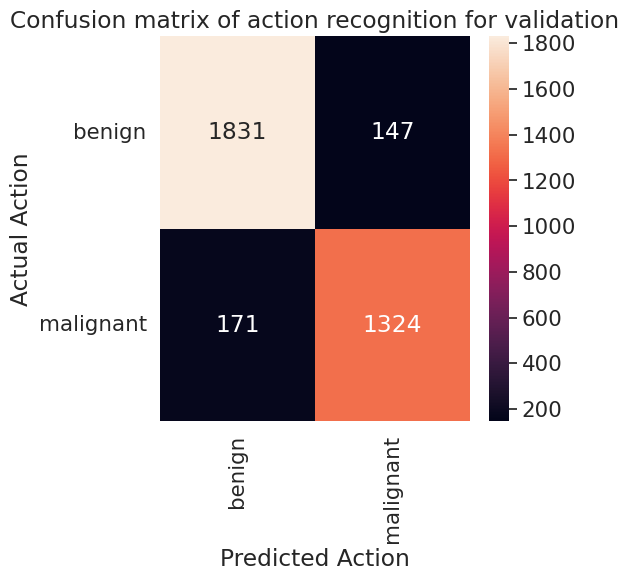

In [60]:
!pip install seaborn
import seaborn as sns
test_predictions = (model.predict(test_ds) > 0.5).astype(int)

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(5, 5)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(test_labels, test_predictions, ["benign", "malignant"], "validation")



In [ ]:
# TODO: pomyslec co zrobic z dysproporcja wsrod klas

In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MeIrYdYxQFxlcIiqQ5Bq3H2txwCwhhNgOfhZqmj7293w',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'skincancer-donotdelete-pr-mcwsmgkoxtaa7r'
object_key = 'efficient_net_weights_transfer_balanced_final.zip'

streaming_body_3 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

